### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
# from src.RetFound import get_retfound
from src.FocalLoss import FocalLoss
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (384,384)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'final_icdr'
TEST_SIZE = 0.2
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN =  [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'swinv2'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no,abnormal
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no,abnormal
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no,abnormal
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no,abnormal
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no,abnormal


In [4]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))

Train data shape: (4130, 25)
Test data shape: (1033, 25)


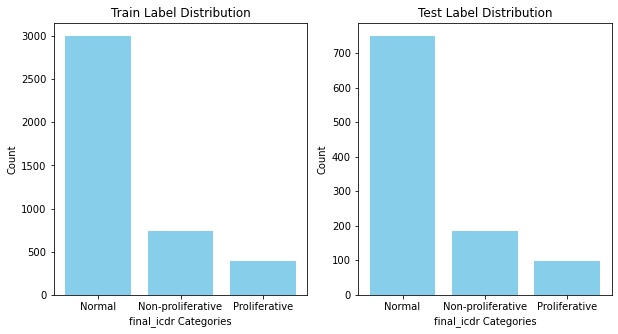

Getting validation set...


In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_val = df_test

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((SHAPE)),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [11]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


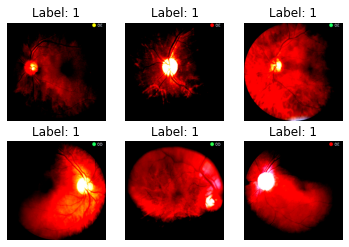

In [12]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break

### Model

In [13]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
from transformers import ConvNextV2Model, ConvNextV2ForImageClassification,AutoModelForImageClassification
import torch

# Load the pre-trained ConvNeXt V2 model
model_name = "microsoft/swinv2-large-patch4-window12to24-192to384-22kto1k-ft"
model = AutoModelForImageClassification.from_pretrained(model_name)

# Modify the classifier head according to the new number of classes
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [14]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [ 737 2999  394]


In [ ]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 1033/1033 [01:36<00:00, 10.71it/s]


Epoch 1, Train Loss: 0.14564068971784302, Val Loss: 0.1104655106304464, F1 Score: 0.6595440385098121, acc0.8180058083252663
cm[[ 66  93  26]
 [ 12 717  21]
 [ 17  19  62]]


100%|██████████| 1033/1033 [01:11<00:00, 14.40it/s]


Epoch 2, Train Loss: 0.09818894677870982, Val Loss: 0.07500756734511753, F1 Score: 0.741781228747751, acc0.8209099709583737
cm[[153  19  13]
 [ 92 626  32]
 [ 17  12  69]]


100%|██████████| 1033/1033 [01:09<00:00, 14.91it/s]


Epoch 3, Train Loss: 0.08626679756092519, Val Loss: 0.07286123032384653, F1 Score: 0.7694078029480361, acc0.8606001936108422
cm[[148  26  11]
 [ 45 676  29]
 [ 19  14  65]]


100%|██████████| 1033/1033 [01:08<00:00, 15.13it/s]


Epoch 4, Train Loss: 0.06682893806802374, Val Loss: 0.07532132358471622, F1 Score: 0.7823627563763744, acc0.8741529525653436
cm[[133  43   9]
 [ 20 703  27]
 [ 17  14  67]]


100%|██████████| 1033/1033 [01:13<00:00, 14.12it/s]


Epoch 5, Train Loss: 0.056086486507509206, Val Loss: 0.07522557383678595, F1 Score: 0.7452740749958656, acc0.8276863504356244
cm[[148  21  16]
 [ 81 636  33]
 [ 17  10  71]]


100%|██████████| 1033/1033 [01:08<00:00, 15.02it/s]


Epoch 6, Train Loss: 0.04784828371235302, Val Loss: 0.07844816770380833, F1 Score: 0.7692131035523205, acc0.8470474346563408
cm[[162  17   6]
 [ 74 646  30]
 [ 21  10  67]]


100%|██████████| 1033/1033 [01:09<00:00, 14.92it/s]


Epoch 7, Train Loss: 0.040636656762722836, Val Loss: 0.12674637875915615, F1 Score: 0.7752930307323634, acc0.8818973862536302
cm[[151  30   4]
 [ 33 712   5]
 [ 24  26  48]]


100%|██████████| 1033/1033 [01:12<00:00, 14.31it/s]


Epoch 8, Train Loss: 0.03288481819522513, Val Loss: 0.12956263387788547, F1 Score: 0.7869395143223201, acc0.8867376573088093
cm[[134  48   3]
 [ 13 728   9]
 [ 19  25  54]]


100%|██████████| 1033/1033 [01:12<00:00, 14.17it/s]


Epoch 9, Train Loss: 0.02711107669412572, Val Loss: 0.1522002427483929, F1 Score: 0.7334139851783643, acc0.797676669893514
cm[[170  10   5]
 [137 591  22]
 [ 19  16  63]]


100%|██████████| 1033/1033 [01:08<00:00, 15.06it/s]


Epoch 10, Train Loss: 0.027142586633311334, Val Loss: 0.10241274238970198, F1 Score: 0.7811062916169328, acc0.8731848983543078
cm[[139  36  10]
 [ 22 697  31]
 [ 15  17  66]]


100%|██████████| 1033/1033 [01:09<00:00, 14.77it/s]


Epoch 11, Train Loss: 0.01909380621987199, Val Loss: 0.13897592566332567, F1 Score: 0.7878054269437601, acc0.8780251694094869
cm[[134  38  13]
 [ 20 704  26]
 [ 14  15  69]]


100%|██████████| 1033/1033 [01:07<00:00, 15.31it/s]


Epoch 12, Train Loss: 0.021675201015129802, Val Loss: 0.12664714624479978, F1 Score: 0.7789429856490142, acc0.872216844143272
cm[[153  27   5]
 [ 44 692  14]
 [ 20  22  56]]


100%|██████████| 1033/1033 [01:09<00:00, 14.79it/s]


Epoch 13, Train Loss: 0.022056849313581643, Val Loss: 0.13148373805686944, F1 Score: 0.7826469180583894, acc0.8731848983543078
cm[[153  25   7]
 [ 44 690  16]
 [ 19  20  59]]


100%|██████████| 1033/1033 [01:15<00:00, 13.60it/s]


Epoch 14, Train Loss: 0.01880777144330845, Val Loss: 0.12348838558400196, F1 Score: 0.7687872771560995, acc0.8547918683446273
cm[[162  16   7]
 [ 70 661  19]
 [ 22  16  60]]


100%|██████████| 1033/1033 [01:09<00:00, 14.85it/s]


Epoch 15, Train Loss: 0.01685294282915809, Val Loss: 0.1271502291187954, F1 Score: 0.7919702409445378, acc0.8751210067763795
cm[[149  30   6]
 [ 38 689  23]
 [ 19  13  66]]


100%|██████████| 1033/1033 [01:09<00:00, 14.80it/s]


Epoch 16, Train Loss: 0.01210855675381869, Val Loss: 0.14149556854807108, F1 Score: 0.8026419346220415, acc0.8906098741529526
cm[[140  38   7]
 [ 16 717  17]
 [ 15  20  63]]


 36%|███▌      | 92/259 [01:46<03:12,  1.15s/it]

### Image quality assessment

In [ ]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

In [ ]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


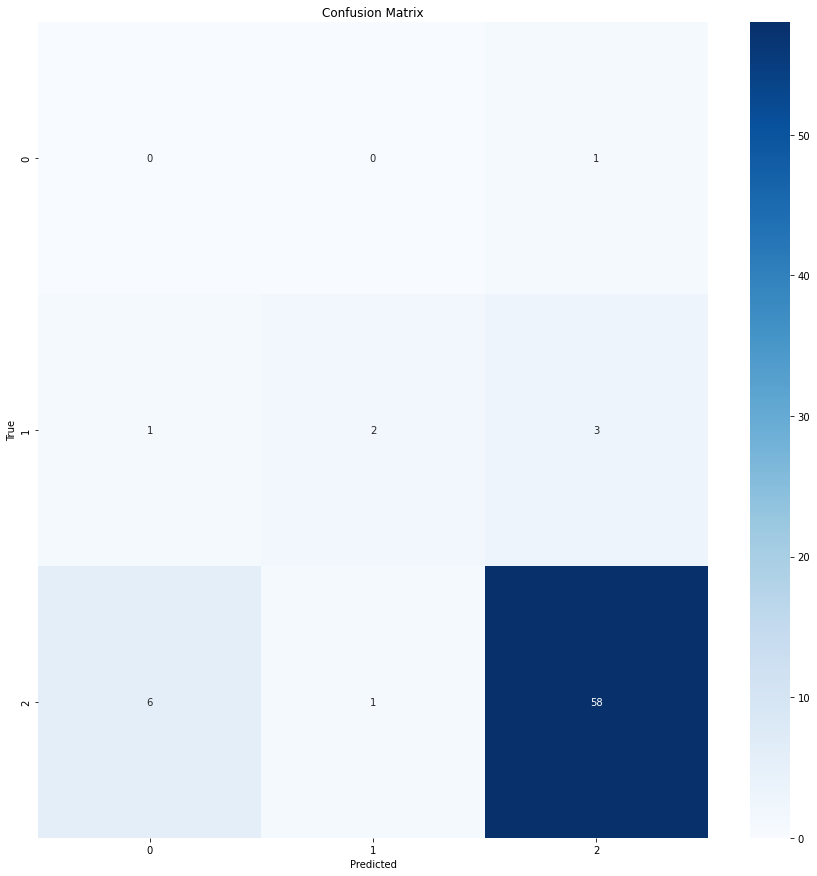

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.33      0.44         6
           2       0.94      0.89      0.91        65

    accuracy                           0.83        72
   macro avg       0.53      0.41      0.45        72
weighted avg       0.90      0.83      0.86        72

##################################################  Saliency Maps  ##################################################

Class 0:


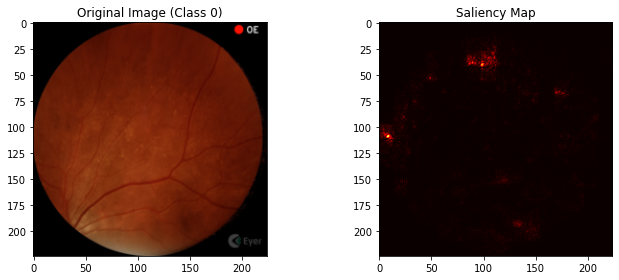

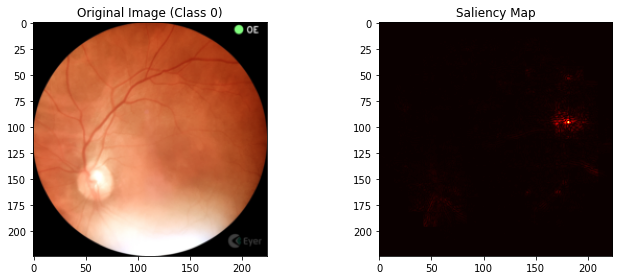

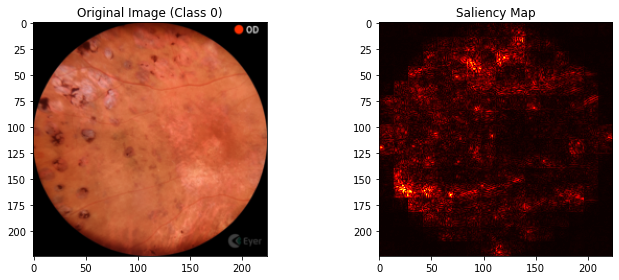

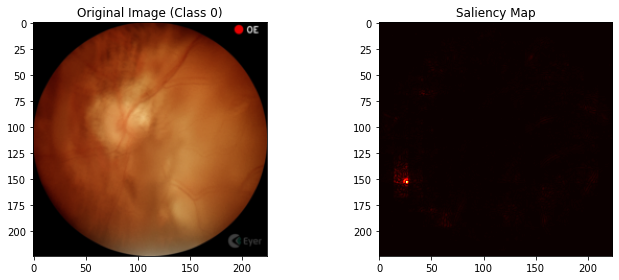

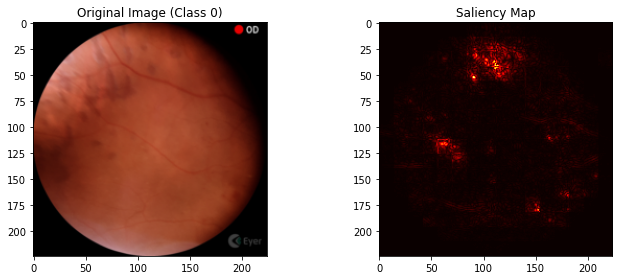

Class 1:


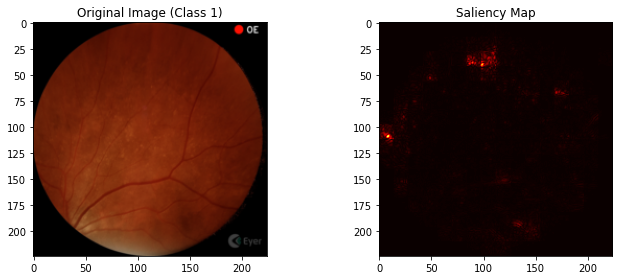

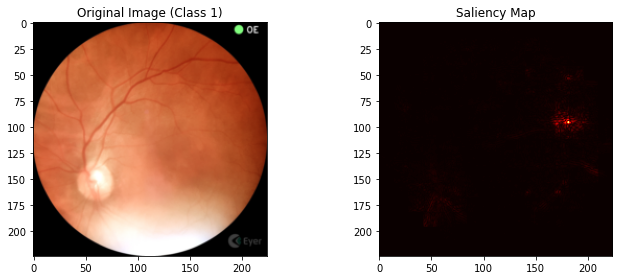

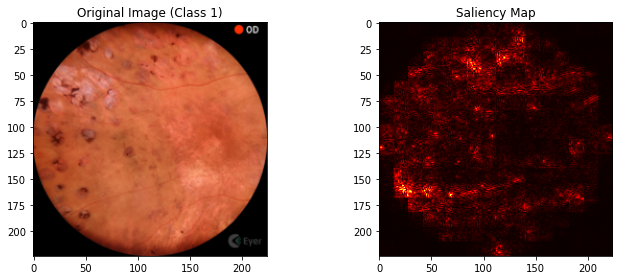

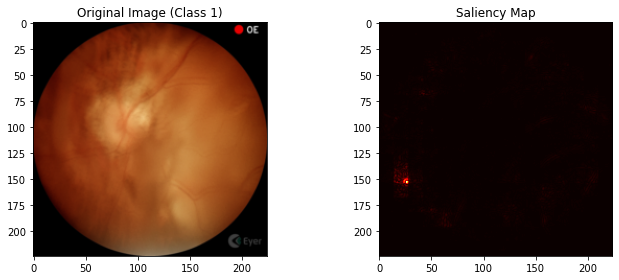

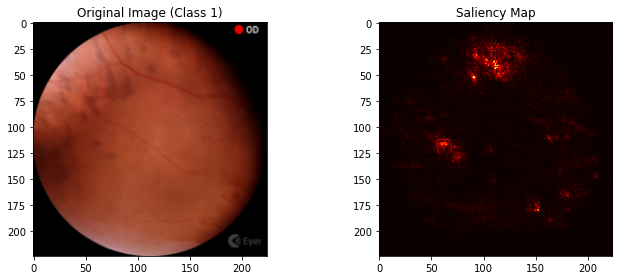

Class 2:


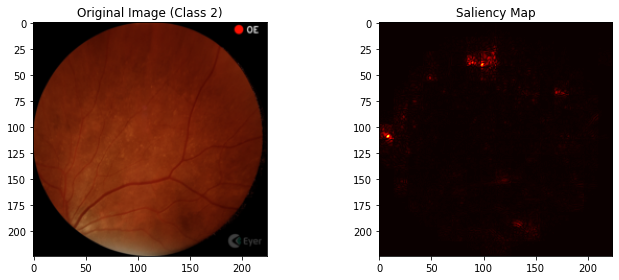

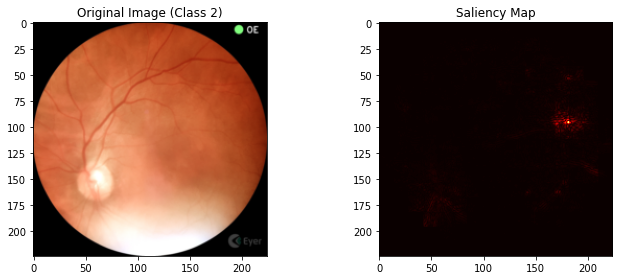

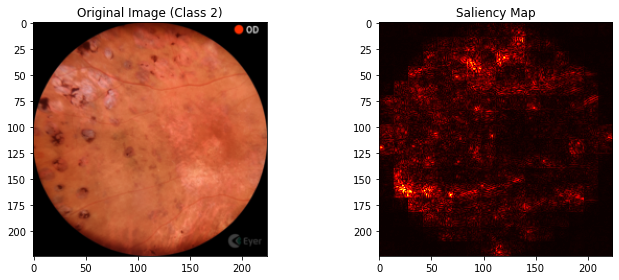

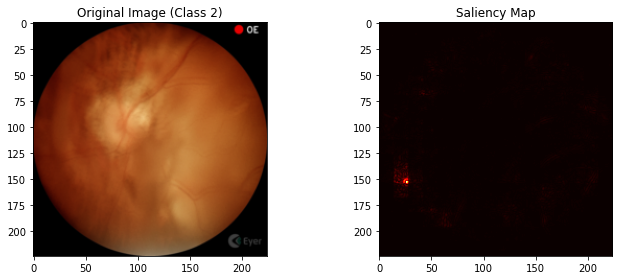

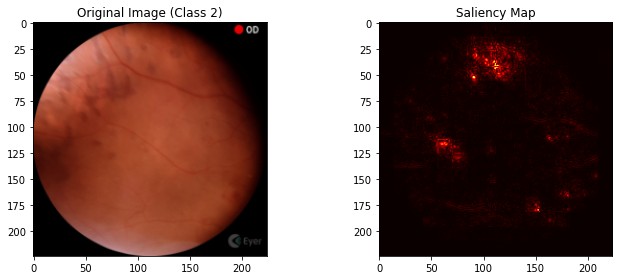

In [17]:
test(model, inadequate_dataloader, saliency=True, device=device)